<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/084_CLIP_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/84_CLIP_Multimodal.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 📎 CLIP: Jak połączyć Obraz z Tekstem?

CLIP to model **Dwusiwieżowy (Two-Tower)**:
1.  **Image Encoder:** Zamienia obrazek na wektor (np. ResNet lub ViT).
2.  **Text Encoder:** Zamienia tekst na wektor (np. Transformer/BERT).

**Trening (Contrastive Learning):**
Wrzucamy do modelu pary (Obrazek, Podpis).
*   Obrazek psa + Tekst "Pies" -> **Przyciągaj** (Wektory blisko).
*   Obrazek psa + Tekst "Banan" -> **Odpychaj** (Wektory daleko).

Dzięki temu powstaje **Wspólna Przestrzeń (Shared Embedding Space)**, gdzie słowa i obrazy o tym samym znaczeniu leżą obok siebie.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EMBED_DIM = 256   # Rozmiar wspólnej przestrzeni (np. 512 w oryginale)
TEMP = 0.07       # Temperatura Softmaxa (dla kontrastu)

print(f"Urządzenie: {DEVICE}")

Urządzenie: cuda


## Krok 1: Wieże (Encoders)

W prawdziwym CLIP używa się potężnych modeli (ViT + GPT-2).
My użyjemy prostych atrap (Mock), które po prostu rzutują losowe dane na wymiar `EMBED_DIM`.
Ważne jest to, co dzieje się **później** (matematyka łączenia).

In [2]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Symulacja: Wejście to spłaszczony obrazek (np. 784 px)
        # W praktyce tu byłby ResNet50
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, EMBED_DIM)
        )

    def forward(self, x):
        return self.net(x)

class TextEncoder(nn.Module):
    def __init__(self, vocab_size=1000):
        super().__init__()
        # Symulacja: Prosty Embedding + uśrednianie
        # W praktyce tu byłby BERT/Transformer
        self.embedding = nn.Embedding(vocab_size, EMBED_DIM)
    
    def forward(self, x):
        # x: [Batch, Seq_Len]
        embedded = self.embedding(x)
        # Uśredniamy słowa, żeby dostać jeden wektor zdania (Global Average Pooling)
        return embedded.mean(dim=1) 

print("Wieże zdefiniowane.")

Wieże zdefiniowane.


## Krok 2: Model CLIP (Spinamy to razem)

To jest serce modelu.
1.  Kodujemy obrazy ($I_e$).
2.  Kodujemy teksty ($T_e$).
3.  Normalizujemy wektory (żeby miały długość 1).
4.  Liczymy **Macierz Podobieństwa** (Dot Product): $I_e \times T_e^T$.

Wynik to szachownica:
*   Przekątna: (Obrazek 1, Tekst 1), (Obrazek 2, Tekst 2)... -> To są pary poprawne.
*   Reszta: Pary błędne.

In [3]:
class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        
        # Temperatura (uczymy się jej, żeby model sam dobrał ostrość)
        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def forward(self, images, text):
        # 1. Kodowanie
        img_features = self.image_encoder(images)
        text_features = self.text_encoder(text)
        
        # 2. Normalizacja (L2 Norm) - kluczowe dla Cosine Similarity!
        img_features = img_features / img_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        
        # 3. Macierz Podobieństwa (Logits)
        # [Batch, Dim] @ [Dim, Batch] -> [Batch, Batch]
        logit_scale = self.temperature.exp()
        logits_per_image = logit_scale * img_features @ text_features.t()
        logits_per_text = logits_per_image.t()
        
        return logits_per_image, logits_per_text

model = CLIP().to(DEVICE)
print("Model CLIP gotowy.")

Model CLIP gotowy.


## Symulacja Zero-Shot Prediction

Wyobraź sobie, że model jest już wytrenowany.
Mamy zdjęcie (np. Psa).
Chcemy sprawdzić, czy to "Pies", "Kot" czy "Samochód".

W klasycznym ML musielibyśmy trenować nową warstwę klasyfikującą (Softmax na 3 klasy).
W CLIP po prostu tworzymy 3 prompty tekstowe i sprawdzamy, który pasuje najbardziej.

--- MACIERZ PODOBIEŃSTWA (Image vs Text) ---
tensor([[ 0.9983,  0.1625, -0.9983],
        [ 0.1625,  0.9983, -0.1625],
        [-0.9983, -0.1625,  0.9983]], device='cuda:0')


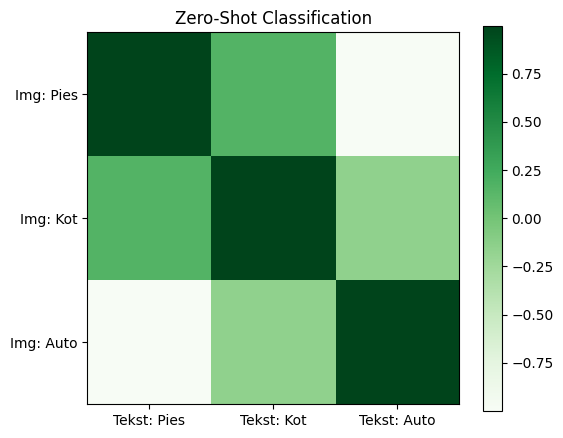

In [4]:
# SYMULACJA ZACHOWANIA PO TRENINGU
# Ponieważ nie trenowaliśmy modelu (brak danych COCO/LAION), 
# ręcznie stworzymy wektory, które "udają" wytrenowane reprezentacje.

batch_size = 3

# Wyobraźmy sobie przestrzeń 2D (cecha X, cecha Y)
# Obrazek 1 (Pies): [0.9, 0.1]
# Obrazek 2 (Kot):  [0.1, 0.9]
# Obrazek 3 (Auto): [-0.9, -0.1]

fake_img_embeds = torch.tensor([
    [0.9, 0.1], 
    [0.1, 0.9],
    [-0.9, -0.1]
]).to(DEVICE)

# Teksty (Prompty):
# Tekst A ("Zdjęcie psa"): [0.95, 0.05] (Bardzo blisko psa)
# Tekst B ("Zdjęcie kota"): [0.05, 0.95]
# Tekst C ("Zdjęcie auta"): [-0.95, -0.05]

fake_text_embeds = torch.tensor([
    [0.95, 0.05],
    [0.05, 0.95],
    [-0.95, -0.05]
]).to(DEVICE)

# Normalizacja
fake_img_embeds = F.normalize(fake_img_embeds, dim=1)
fake_text_embeds = F.normalize(fake_text_embeds, dim=1)

# Obliczamy podobieństwo (To robi CLIP w środku)
similarity = fake_img_embeds @ fake_text_embeds.t()

print("--- MACIERZ PODOBIEŃSTWA (Image vs Text) ---")
print(similarity)

# Wizualizacja
plt.figure(figsize=(6, 5))
plt.imshow(similarity.cpu().numpy(), cmap='Greens')
plt.colorbar()
plt.xticks(range(3), ["Tekst: Pies", "Tekst: Kot", "Tekst: Auto"])
plt.yticks(range(3), ["Img: Pies", "Img: Kot", "Img: Auto"])
plt.title("Zero-Shot Classification")
plt.show()

In [5]:
# PREDYKCJA DLA OBRAZKA NR 1 (Pies)
probs = F.softmax(similarity[0] * 10.0, dim=0) # *10 to temperatura

classes = ["Pies", "Kot", "Auto"]
best_idx = probs.argmax().item()

print(f"Mamy zdjęcie tajemniczego obiektu (Obrazek 1).")
print("Pytamy CLIPa: Co to jest?")
for i, p in enumerate(probs):
    print(f"- {classes[i]}: {p*100:.2f}%")

print(f"\nWerdykt: To jest {classes[best_idx]}!")

Mamy zdjęcie tajemniczego obiektu (Obrazek 1).
Pytamy CLIPa: Co to jest?
- Pies: 99.98%
- Kot: 0.02%
- Auto: 0.00%

Werdykt: To jest Pies!


## 🧠 Podsumowanie: Uniwersalny Tłumacz

To, co zobaczyliśmy na macierzy (ciemna przekątna), to dowód na działanie CLIPa.
Wektor obrazu psa "przytulił się" do wektora tekstu "Pies".

**Dlaczego to jest SOTA?**
1.  **Wyszukiwarka obrazów:** Możesz wpisać w Google Zdjęcia "Pies na plaży o zachodzie słońca", a CLIP znajdzie zdjęcie, które pasuje do opisu, nawet jeśli nikt go tak nie otagował.
2.  **Generowanie (DALL-E):** Generatory obrazów działają "od tyłu". Próbują stworzyć z szumu taki obrazek, który wg CLIPa będzie pasował do Twojego promptu.